In [2]:
import os

In [4]:
print(os.listdir("D:/Projects-Ravi/Data Exploration step by step Python/Inputs"))

['breed_labels.csv', 'color_labels.csv', 'state_labels.csv', 'test', 'test_images', 'test_metadata', 'test_sentiment', 'train', 'train_images', 'train_metadata', 'train_sentiment']


In [15]:
#libraries
import numpy as np 
import pandas as pd 
import os
import json
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from PIL import Image
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import gc
from catboost import CatBoostClassifier
from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import random
import warnings
warnings.filterwarnings("ignore")
from functools import partial
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)
import os
import scipy as sp
from math import sqrt
from collections import Counter
from sklearn.metrics import confusion_matrix as sk_cmatrix

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import RandomForestClassifier
import langdetect
import eli5
from IPython.display import display 

from sklearn.metrics import cohen_kappa_score
def kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [16]:
breeds = pd.read_csv('D:/projects-Ravi/Data Exploration step by step Python/Inputs/breed_labels.csv')
colors = pd.read_csv('D:/projects-Ravi/Data Exploration step by step Python/Inputs/color_labels.csv')
states = pd.read_csv('D:/projects-Ravi/Data Exploration step by step Python/Inputs//state_labels.csv')

train = pd.read_csv('D:/projects-Ravi/Data Exploration step by step Python/Inputs/train/train.csv')
test = pd.read_csv('D:/projects-Ravi/Data Exploration step by step Python/Inputs/test/test.csv')
sub = pd.read_csv('D:/projects-Ravi/Data Exploration step by step Python/Inputs/test/sample_submission.csv')

train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
all_data = pd.concat([train, test])


In [17]:
print(os.listdir("D:/projects-Ravi/Data Exploration step by step Python/Inputs"))


['breed_labels.csv', 'color_labels.csv', 'state_labels.csv', 'test', 'test_images', 'test_metadata', 'test_sentiment', 'train', 'train_images', 'train_metadata', 'train_sentiment']


In [18]:
train.drop('Description', axis=1).head()

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize  FurLength  Vaccinated  Dewormed  Sterilized  Health  \
0             1          1           2         2           2       1   
1             2          2           3         3           3       1   
2             2          2           1         1           2       1   
3             2          1           1         1           2       1   
4             2          1           2         2           2       1   

   Quantity  Fee  State                         RescuerID  VideoAmt  \
0         1  100  41326  8480853f516546f6cf33aa88cd76c379         0   
1         1    0  41401  3082c7125d8fb66f7dd4bff4192c8b14         0   
2         1    0  41326  fa90fa5b1ee11c86938398b60abc32cb         0   
3         1  150  41401  9238e4f44c71a75282e62f7136c6b240         0   
4         1    0  41326  95481e953f8aed9ec3d16fc4509537e8         0   

       PetID  PhotoAmt  AdoptionSpeed dataset_type  
0  86e1089a3       1.0              2        train  
1  6296e909a       2.0              0        train  
2  3422e4906       7.0              3        train  
3  5842f1ff5       8.0              2        train  
4  850a43f90       3.0              2        train

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 25 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

Text(0.5, 1.0, 'Adoption speed classes counts')

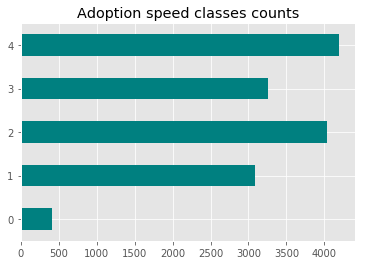

In [20]:
#Target: Adoption speed
#•0 - Pet was adopted on the same day as it was listed.
#•1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
#•2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
#•3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
#•4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days). 
train['AdoptionSpeed'].value_counts().sort_index().plot('barh', color='teal');
plt.title('Adoption speed classes counts')

In [21]:
train['AdoptionSpeed'].value_counts(normalize=True).sort_index()

0    0.027346
1    0.206096
2    0.269259
3    0.217368
4    0.279931
Name: AdoptionSpeed, dtype: float64

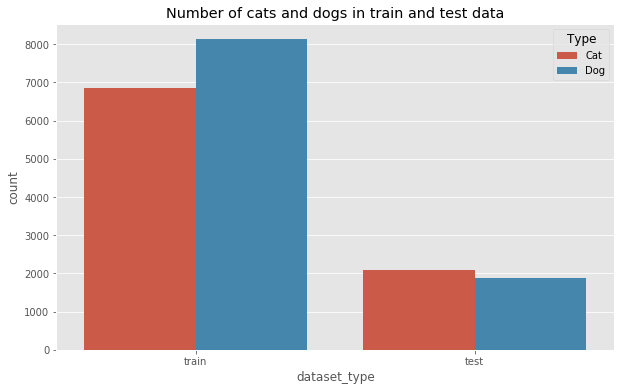

In [22]:

#Type

#1 - Dog, 2 - Cat

all_data['Type'] = all_data['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')
plt.figure(figsize=(10, 6));
sns.countplot(x='dataset_type', data=all_data, hue='Type');
plt.title('Number of cats and dogs in train and test data');



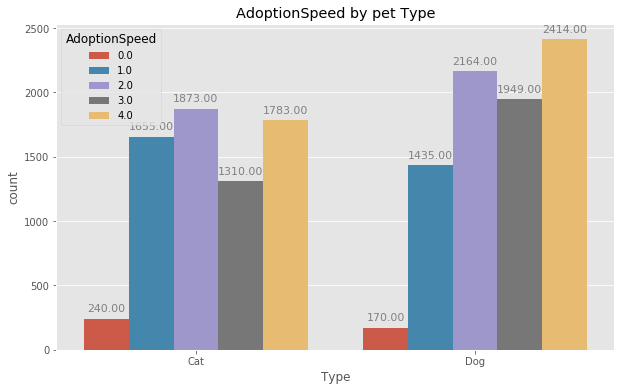

In [23]:
plt.figure(figsize=(10, 6));
g = sns.countplot(x='Type', data=all_data.loc[all_data['dataset_type'] == 'train'], hue='AdoptionSpeed');
plt.title('AdoptionSpeed by pet Type');
ax=g.axes #annotate axis = seaborn axis
for p in ax.patches:
     ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points')

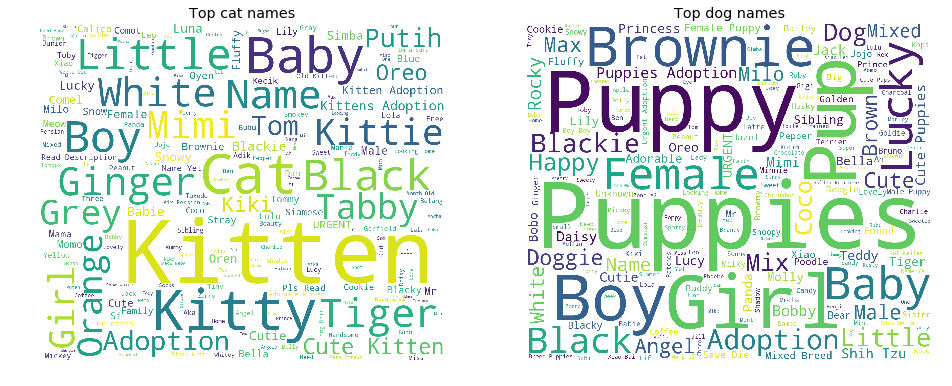

In [24]:
fig, ax = plt.subplots(figsize = (16, 12))
plt.subplot(1, 2, 1)
text_cat = ' '.join(all_data.loc[all_data['Type'] == 'Cat', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_cat)
plt.imshow(wordcloud)
plt.title('Top cat names')
plt.axis("off")

plt.subplot(1, 2, 2)
text_dog = ' '.join(all_data.loc[all_data['Type'] == 'Dog', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_dog)
plt.imshow(wordcloud)
plt.title('Top dog names')
plt.axis("off")

plt.show()

In [25]:
print('Most popular pet names and AdoptionSpeed')
for n in train['Name'].value_counts().index[:5]:
    print(n)
    print(train.loc[train['Name'] == n, 'AdoptionSpeed'].value_counts().sort_index())
    print('')

Most popular pet names and AdoptionSpeed
Baby
0     2
1    11
2    15
3    11
4    27
Name: AdoptionSpeed, dtype: int64

Lucky
0     5
1    14
2    16
3    12
4    17
Name: AdoptionSpeed, dtype: int64

No Name
0     3
1    14
2    11
3     6
4    20
Name: AdoptionSpeed, dtype: int64

Brownie
0     1
1    11
2    14
3    12
4    16
Name: AdoptionSpeed, dtype: int64

Mimi
0     3
1    12
2    13
3     7
4    17
Name: AdoptionSpeed, dtype: int64



In [26]:
train['Name'] = train['Name'].fillna('Unnamed')
test['Name'] = test['Name'].fillna('Unnamed')
all_data['Name'] = all_data['Name'].fillna('Unnamed')

train['No_name'] = 0
train.loc[train['Name'] == 'Unnamed', 'No_name'] = 1
test['No_name'] = 0
test.loc[test['Name'] == 'Unnamed', 'No_name'] = 1
all_data['No_name'] = 0
all_data.loc[all_data['Name'] == 'Unnamed', 'No_name'] = 1

print(f"Rate of unnamed pets in train data: {train['No_name'].sum() * 100 / train['No_name'].shape[0]:.4f}%.")
print(f"Rate of unnamed pets in test data: {test['No_name'].sum() * 100 / test['No_name'].shape[0]:.4f}%.")

Rate of unnamed pets in train data: 8.4173%.
Rate of unnamed pets in test data: 7.6748%.


In [27]:
pd.crosstab(train['No_name'], train['AdoptionSpeed'], normalize='index')

AdoptionSpeed         0         1         2         3         4
No_name                                                        
0              0.027966  0.205302  0.271211  0.221470  0.274051
1              0.020602  0.214739  0.248019  0.172742  0.343899

Text(0.5, 1.0, 'AdoptionSpeed and having a name')

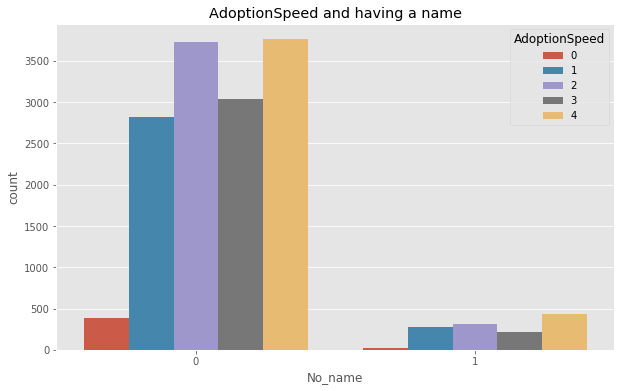

In [28]:
plt.figure(figsize=(10, 6));
sns.countplot(x='No_name', data=train, hue='AdoptionSpeed');
plt.title('AdoptionSpeed and having a name')

In [29]:
all_data.loc[all_data['Name'].str.contains('Occhi Belli'), 'Description']


14918    Occhi Belli nama diberi bermaksud mata cantik. Bg saya mata biru dia cantik sangat tambah lg bila kena cahaya mata dia tukar jadi merah2 sikit.Style gitu. Kucing jalanan ni, saya jaga dia sebab kesian takde mama dia. Asik suka ikut je orang pergi mana. Dah mandikan dia tapi still nampak comot maybe dh lama terbiar. Jadi dia perlukan mak bapak baru untuk dijaga. waktu adoption : 10pm - am (after habis kerja) please bring your own carrier
Name: Description, dtype: object

In [30]:
all_data[all_data['Name'].apply(lambda x: len(str(x))) < 3]['Name'].unique()

array(['H3', 'Z3', 'C', 'BB', 'QQ', 'Y1', 'H1', 'D9', 'Y4', 'Z4', 'DD',
       'M2', 'H6', 'D4', 'JJ', 'F1', 'W7', '1F', 'Q1', '6', 'CJ', '3F',
       'KD', 'G1', 'B3', 'Cc', 'F6', 'Mk', 'A5', 'GM', 'D5', 'EE', 'A4',
       'Q4', 'B', 'CC', 'Y7', 'W6', 'A3', 'A1', 'T1', 'W1', 'M4', 'P5',
       'H2', 'GG', 'Y6', 'Z', 'D7', 'B4', 'C2', 'M8', '3', 'G2', 'ML',
       'DJ', 'PP', '8', 'OJ', 'D', 'F2', 'MJ', 'W8', 'W4', 'C1', 'W2',
       'GR', 'B1', '5', 'Fa', 'Y5', 'M', 'F5', 'Y0', 'B2', 'Q6', 'G3',
       '..', 'S1', 'Qu', 'R9', 'W3', 'R7', 'Tj', 'P3', '7', '!', 'RC',
       'Z2', 'Q3', 'A2', 'QD', 'S', '-', 'R6', 'IV', 'Mo', 'W5', 'F8',
       'M6', 'M9', 'Py', 'Rt', 'F9', 'P6', 'AJ', 'Y3', 'D6', 'T2', 'F4',
       'T3', 'YY', '99', 'F7', 'W+', 'D2', '1', '#1', 'S4', '2', 'Am',
       'P', 'P4', 'R5', 'M3', 'R3', 'JD', 'BJ', 'L', 'KC', 'VV', 'M1',
       '!.', 'V6', 'P1', 'J', 'S3', 'A6', 'Cq', 'M5', 'B5', 'J1', 'O',
       '2F', 'Q2', 'Y2', 'AB', 'A', 'Jo', 'ET', 'A9', 'ST', 'Po', 'KK'

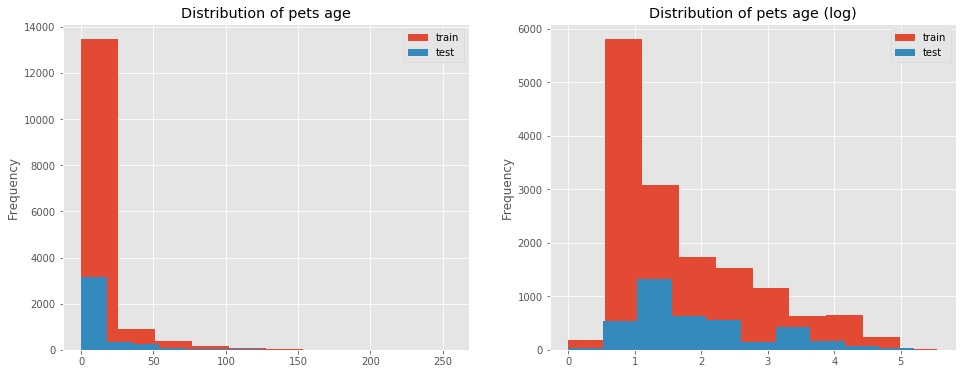

In [31]:
# Age

fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.title('Distribution of pets age');
train['Age'].plot('hist', label='train');
test['Age'].plot('hist', label='test');
plt.legend();

plt.subplot(1, 2, 2)
plt.title('Distribution of pets age (log)');
np.log1p(train['Age']).plot('hist', label='train');
np.log1p(test['Age']).plot('hist', label='test');
plt.legend();

In [32]:
train['Age'].value_counts().head(10)

2     3503
1     2304
3     1966
4     1109
12     967
24     651
5      595
6      558
36     417
8      309
Name: Age, dtype: int64

Text(0.5, 1.0, 'AdoptionSpeed by Type and age')

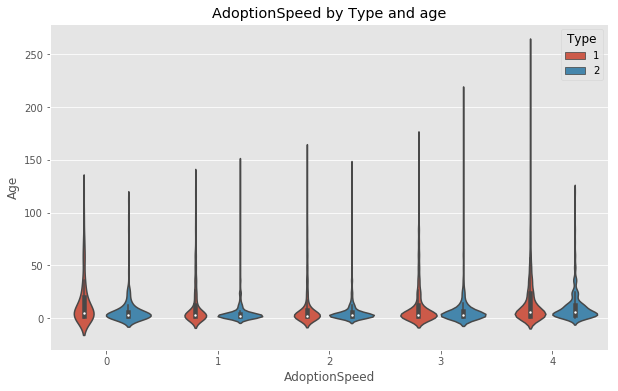

In [33]:
plt.figure(figsize=(10, 6));
sns.violinplot(x="AdoptionSpeed", y="Age", hue="Type", data=train);
plt.title('AdoptionSpeed by Type and age')

In [34]:
data = []
for a in range(5):
    df = train.loc[train['AdoptionSpeed'] == a]

    data.append(go.Scatter(
        x = df['Age'].value_counts().sort_index().index,
        y = df['Age'].value_counts().sort_index().values,
        name = str(a)
    ))
layout = go.Layout(dict(title = "AdoptionSpeed trends by Age",
                  xaxis = dict(title = 'Age (months)'),
                  yaxis = dict(title = 'Counts'),
                  )
                  )
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [35]:
#Breeds¶

#There is a main breed of the pet and secondary if relevant.

# At first let's see whether having secondary breed influences adoption speed.

train['Pure_breed'] = 0
train.loc[train['Breed2'] == 0, 'Pure_breed'] = 1
test['Pure_breed'] = 0
test.loc[test['Breed2'] == 0, 'Pure_breed'] = 1
all_data['Pure_breed'] = 0
all_data.loc[all_data['Breed2'] == 0, 'Pure_breed'] = 1

print(f"Rate of pure breed pets in train data: {train['Pure_breed'].sum() * 100 / train['Pure_breed'].shape[0]:.4f}%.")
print(f"Rate of pure breed pets in test data: {test['Pure_breed'].sum() * 100 / test['Pure_breed'].shape[0]:.4f}%.")


Rate of pure breed pets in train data: 71.7802%.
Rate of pure breed pets in test data: 77.9635%.


Text(0.5, 1.0, 'AdoptionSpeed and having pure breed for cats')

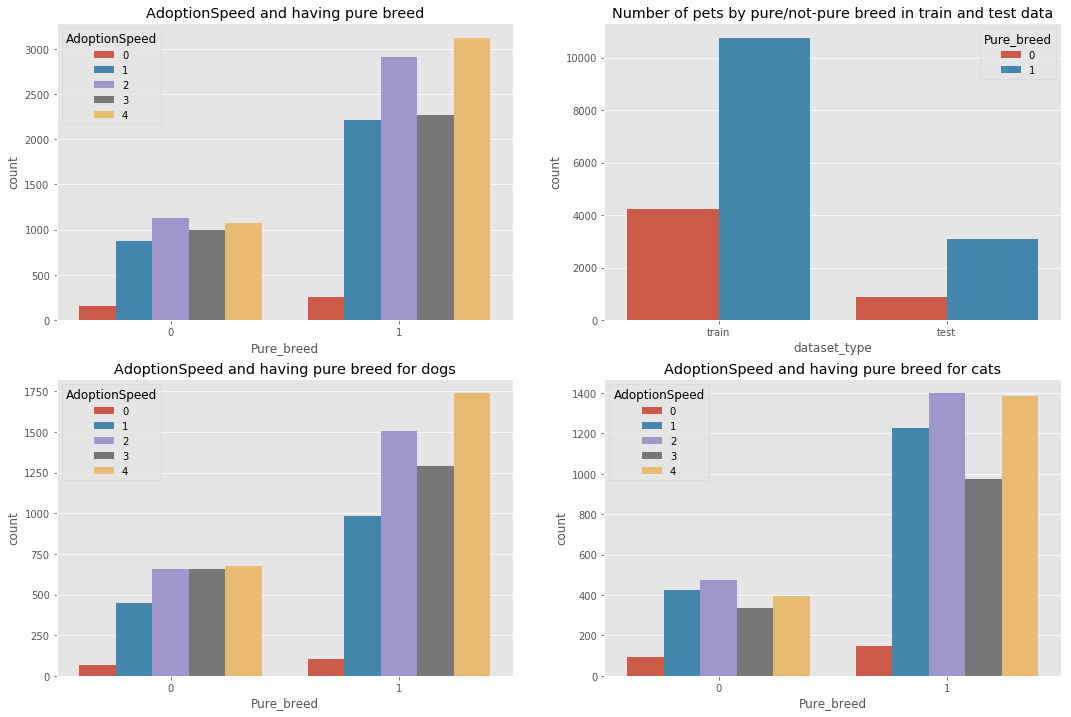

In [37]:
plt.figure(figsize=(18, 12));
plt.subplot(2, 2, 1)
sns.countplot(x='Pure_breed', data=train, hue='AdoptionSpeed');
plt.title('AdoptionSpeed and having pure breed');

plt.subplot(2, 2, 2)
sns.countplot(x='dataset_type', data=all_data, hue='Pure_breed');
plt.title('Number of pets by pure/not-pure breed in train and test data');

plt.subplot(2, 2, 3)
sns.countplot(x='Pure_breed', data=train.loc[train['Type'] == 1], hue='AdoptionSpeed');
plt.title('AdoptionSpeed and having pure breed for dogs');

plt.subplot(2, 2, 4)
sns.countplot(x='Pure_breed', data=train.loc[train['Type'] == 2], hue='AdoptionSpeed');
plt.title('AdoptionSpeed and having pure breed for cats')

In [38]:
breeds_dict = {k: v for k, v in zip(breeds['BreedID'], breeds['BreedName'])}

In [39]:
train['Breed1_name'] = train['Breed1'].apply(lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else 'Unknown')
train['Breed2_name'] = train['Breed2'].apply(lambda x: '_'.join(breeds_dict[x]) if x in breeds_dict else '-')

test['Breed1_name'] = test['Breed1'].apply(lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else 'Unknown')
test['Breed2_name'] = test['Breed2'].apply(lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else '-')

all_data['Breed1_name'] = all_data['Breed1'].apply(lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else 'Unknown')
all_data['Breed2_name'] = all_data['Breed2'].apply(lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else '-')


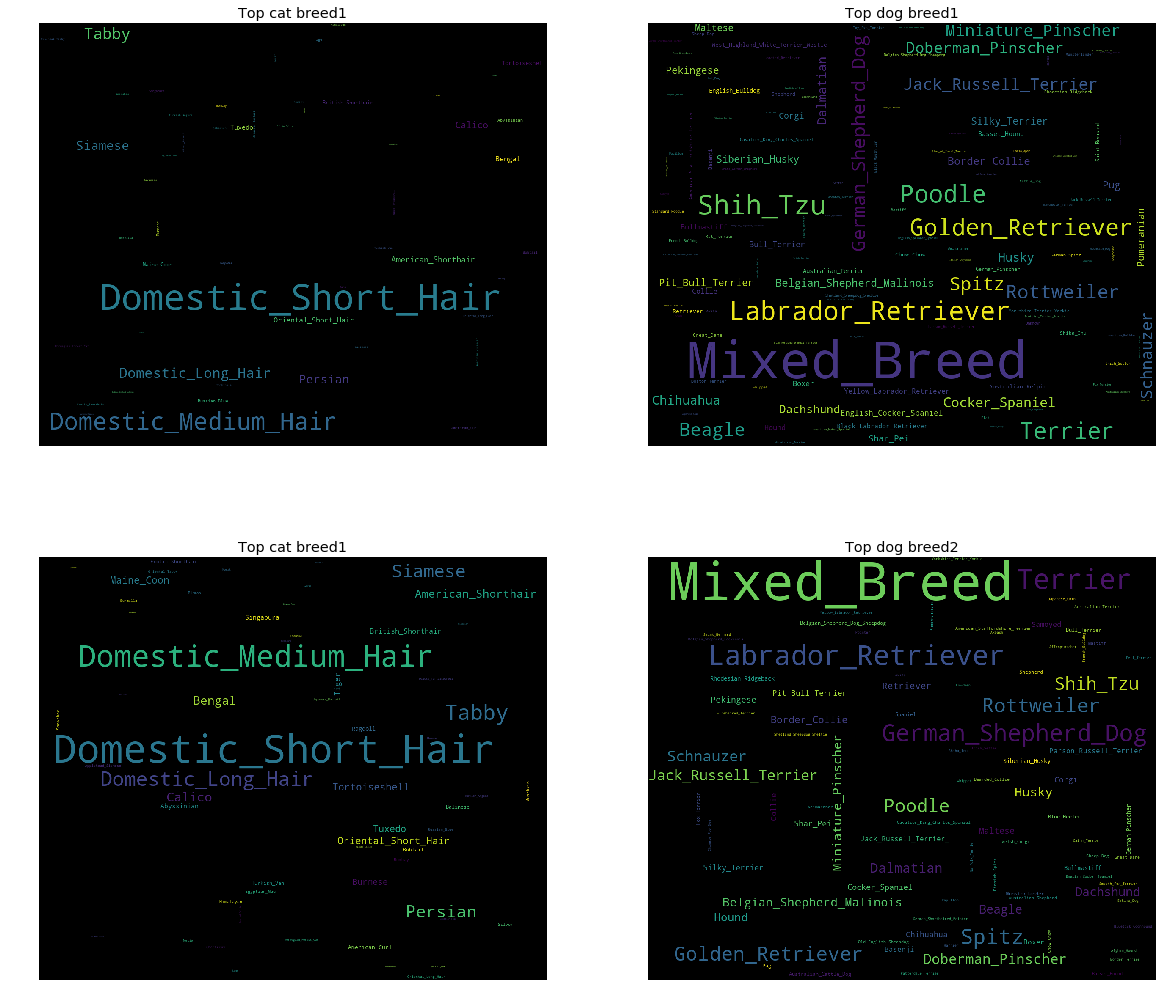

In [40]:
fig, ax = plt.subplots(figsize = (20, 18))
plt.subplot(2, 2, 1)
text_cat1 = ' '.join(all_data.loc[all_data['Type'] == 'Cat', 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text_cat1)
plt.imshow(wordcloud)
plt.title('Top cat breed1')
plt.axis("off")

plt.subplot(2, 2, 2)
text_dog1 = ' '.join(all_data.loc[all_data['Type'] == 'Dog', 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text_dog1)
plt.imshow(wordcloud)
plt.title('Top dog breed1')
plt.axis("off")

plt.subplot(2, 2, 3)
text_cat2 = ' '.join(all_data.loc[all_data['Type'] == 'Cat', 'Breed2_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text_cat2)
plt.imshow(wordcloud)
plt.title('Top cat breed1')
plt.axis("off")

plt.subplot(2, 2, 4)
text_dog2 = ' '.join(all_data.loc[all_data['Type'] == 'Dog', 'Breed2_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text_dog2)
plt.imshow(wordcloud)
plt.title('Top dog breed2')
plt.axis("off")
plt.show()


In [41]:
(all_data['Breed1_name'] + '__' + all_data['Breed2_name']).value_counts().head(15)

Mixed_Breed__-                                5573
Domestic_Short_Hair__-                        4042
Domestic_Medium_Hair__-                       1264
Mixed_Breed__Mixed_Breed                      1188
Tabby__-                                       379
Domestic_Short_Hair__Domestic_Short_Hair       320
Domestic_Long_Hair__-                          244
Shih_Tzu__-                                    204
Poodle__-                                      153
Siamese__-                                     152
Labrador_Retriever__Mixed_Breed                132
Golden_Retriever__-                            123
Domestic_Medium_Hair__Domestic_Medium_Hair     110
Domestic_Medium_Hair__Domestic_Short_Hair      104
Calico__-                                      101
dtype: int64

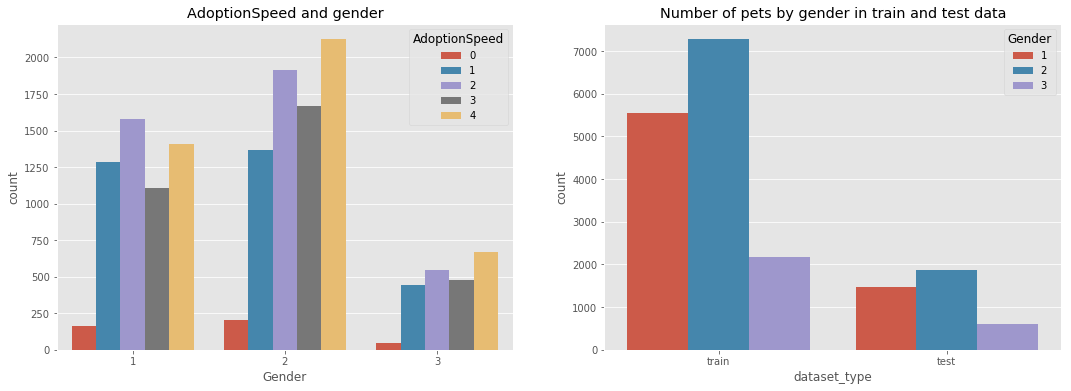

In [42]:
#Gender

# 1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets
plt.figure(figsize=(18, 6));
plt.subplot(1, 2, 1)
sns.countplot(x='Gender', data=train, hue='AdoptionSpeed');
plt.title('AdoptionSpeed and gender');

plt.subplot(1, 2, 2)
sns.countplot(x='dataset_type', data=all_data, hue='Gender');
plt.title('Number of pets by gender in train and test data');

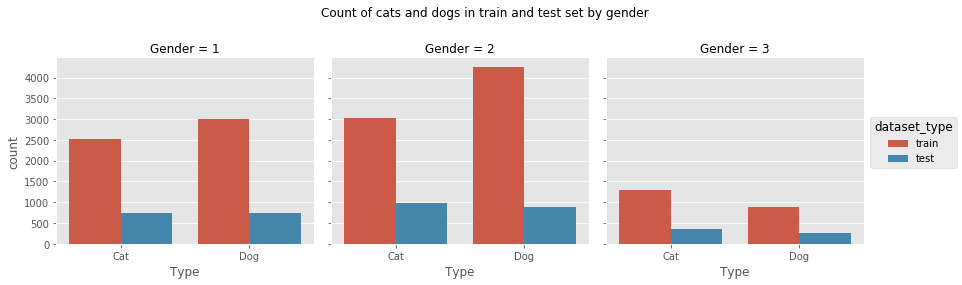

In [43]:
sns.factorplot('Type', col='Gender', data=all_data, kind='count', hue='dataset_type');
plt.subplots_adjust(top=0.8)
plt.suptitle('Count of cats and dogs in train and test set by gender');

In [44]:
# Colors
colors_dict = {k: v for k, v in zip(colors['ColorID'], colors['ColorName'])}
train['Color1_name'] = train['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
train['Color2_name'] = train['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
train['Color3_name'] = train['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

test['Color1_name'] = test['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
test['Color2_name'] = test['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
test['Color3_name'] = test['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

all_data['Color1_name'] = all_data['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
all_data['Color2_name'] = all_data['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
all_data['Color3_name'] = all_data['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

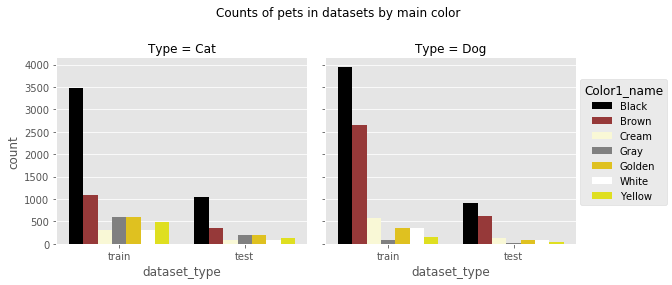

In [45]:
sns.factorplot('dataset_type', col='Type', data=all_data, kind='count', hue='Color1_name', palette=['Black', 'Brown', '#FFFDD0', 'Gray', 'Gold', 'White', 'Yellow']);
plt.subplots_adjust(top=0.8)
plt.suptitle('Counts of pets in datasets by main color');

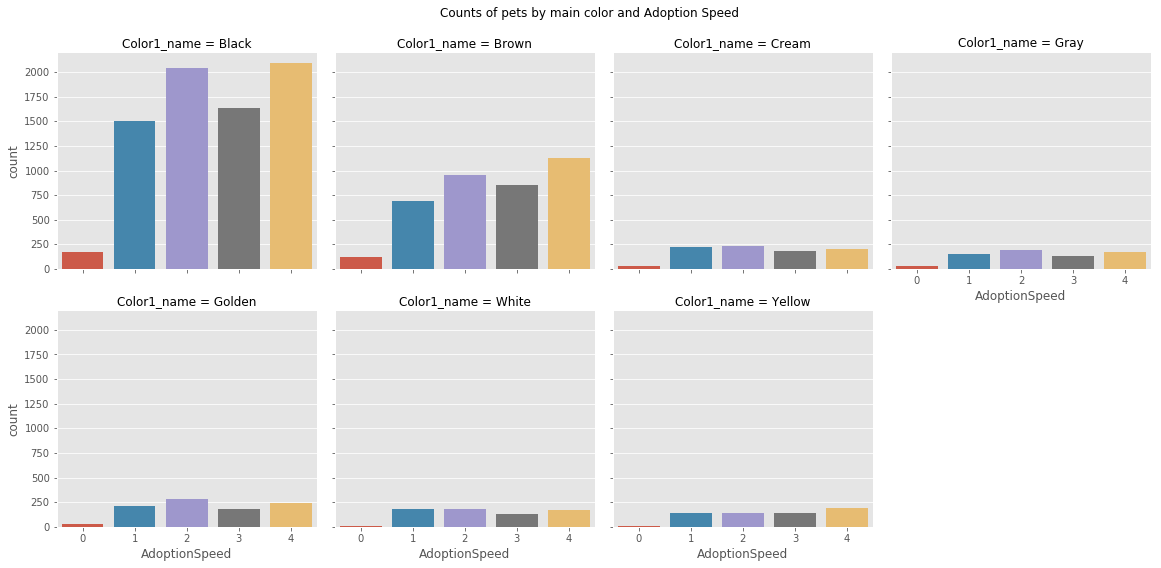

In [46]:
sns.factorplot('AdoptionSpeed', col='Color1_name', data=train, kind='count', col_wrap=4);
plt.subplots_adjust(top=0.9)
plt.suptitle('Counts of pets by main color and Adoption Speed');

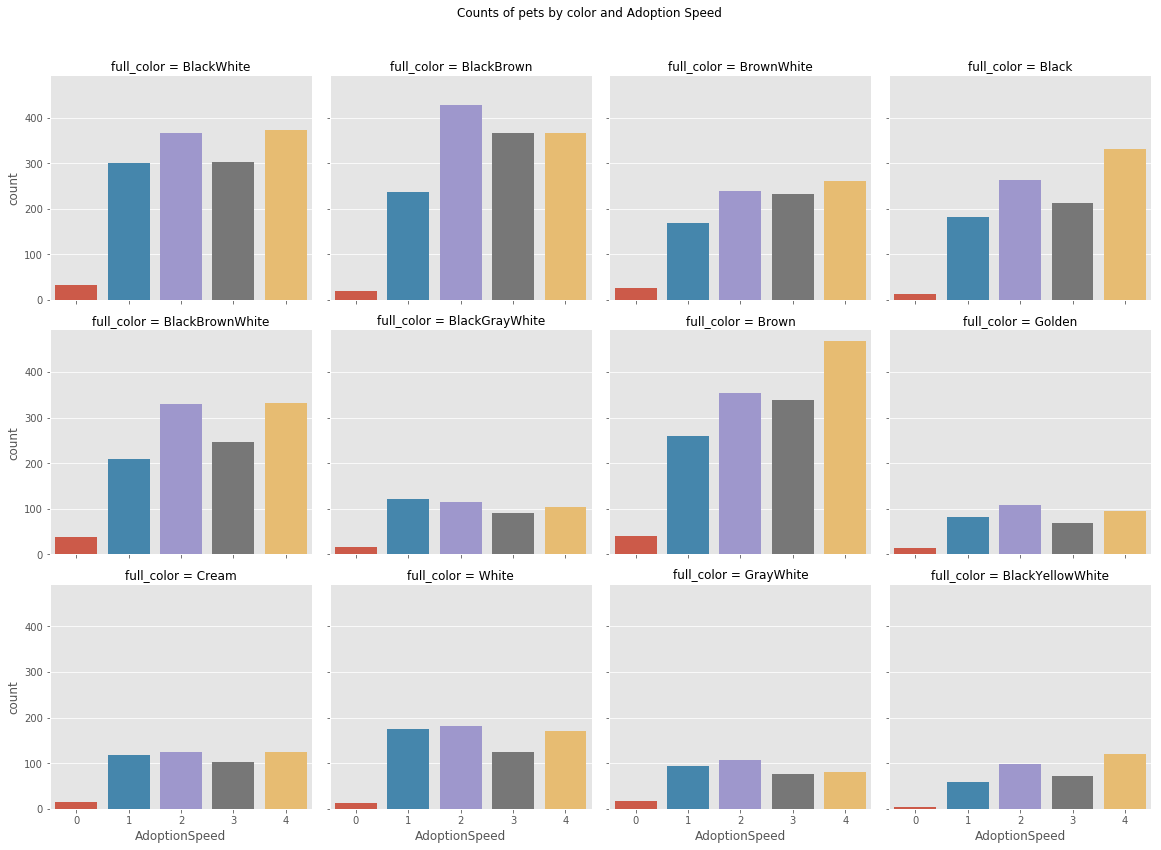

In [47]:
train['full_color'] = (train['Color1_name'] + '__' + train['Color2_name'] + '__' + train['Color3_name']).str.replace('__', '')
test['full_color'] = (test['Color1_name'] + '__' + test['Color2_name'] + '__' + test['Color3_name']).str.replace('__', '')
all_data['full_color'] = (all_data['Color1_name'] + '__' + all_data['Color2_name'] + '__' + all_data['Color3_name']).str.replace('__', '')

sns.factorplot('AdoptionSpeed', col='full_color', data=train.loc[train['full_color'].isin(list(train['full_color'].value_counts().index)[:12])], kind='count', col_wrap=4);
plt.subplots_adjust(top=0.9)
plt.suptitle('Counts of pets by color and Adoption Speed');

In [48]:
gender_dict = {1: 'Male', 2: 'Female', 3: 'Mixed'}
for i in all_data['Type'].unique():
    for j in all_data['Gender'].unique():
        df = all_data.loc[(all_data['Type'] == i) & (all_data['Gender'] == j)]
        top_colors = list(df['full_color'].value_counts().index)[:5]
        j = gender_dict[j]
        print(f"Most popular colors of {j} {i}s: {' '.join(top_colors)}")

Most popular colors of Male Cats: BlackWhite Black GrayWhite YellowWhite BlackGrayWhite
Most popular colors of Female Cats: BlackWhite BlackYellowWhite BlackBrownWhite GrayWhite White
Most popular colors of Mixed Cats: BlackBrownWhite BlackGrayWhite BlackYellowWhite BlackWhite BlackGoldenWhite
Most popular colors of Male Dogs: Brown BlackBrown Black BrownWhite BlackWhite
Most popular colors of Female Dogs: Brown BlackBrown BrownWhite Black BlackWhite
Most popular colors of Mixed Dogs: BlackBrownWhite BlackBrown BlackBrownCream Brown BlackWhite


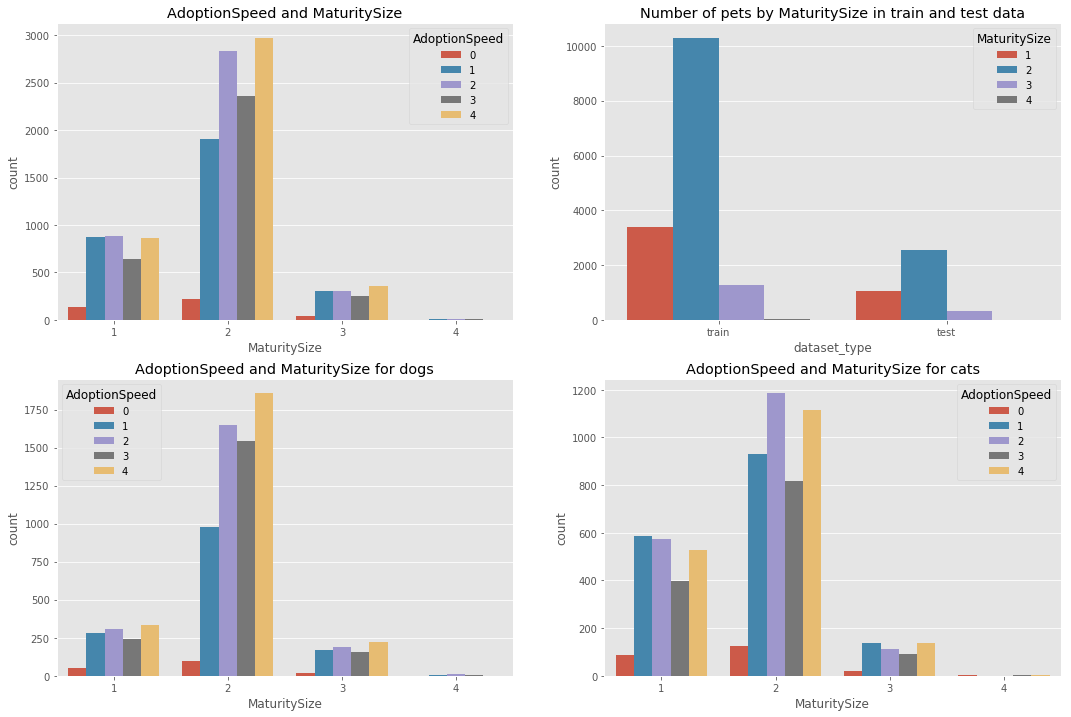

In [49]:
# MatiritySize

# Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)

plt.figure(figsize=(18, 12));
plt.subplot(2, 2, 1)
sns.countplot(x='MaturitySize', data=train, hue='AdoptionSpeed');
plt.title('AdoptionSpeed and MaturitySize');

plt.subplot(2, 2, 2)
sns.countplot(x='dataset_type', data=all_data, hue='MaturitySize');
plt.title('Number of pets by MaturitySize in train and test data');

plt.subplot(2, 2, 3)
sns.countplot(x='MaturitySize', data=train.loc[train['Type'] == 1], hue='AdoptionSpeed');
plt.title('AdoptionSpeed and MaturitySize for dogs');

plt.subplot(2, 2, 4)
sns.countplot(x='MaturitySize', data=train.loc[train['Type'] == 2], hue='AdoptionSpeed');
plt.title('AdoptionSpeed and MaturitySize for cats');


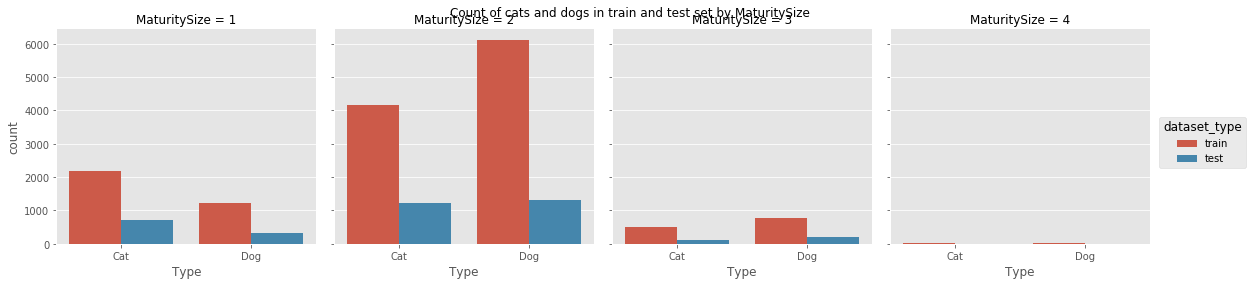

In [50]:
sns.factorplot('Type', col='MaturitySize', data=all_data, kind='count', hue='dataset_type');
plt.subplots_adjust(top=0.9)
plt.suptitle('Count of cats and dogs in train and test set by MaturitySize');

Most common Breeds of Small Cats:


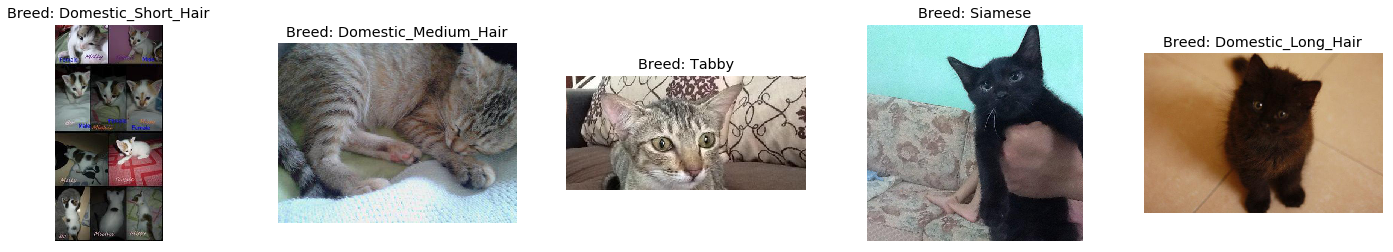

Most common Breeds of Medium Cats:


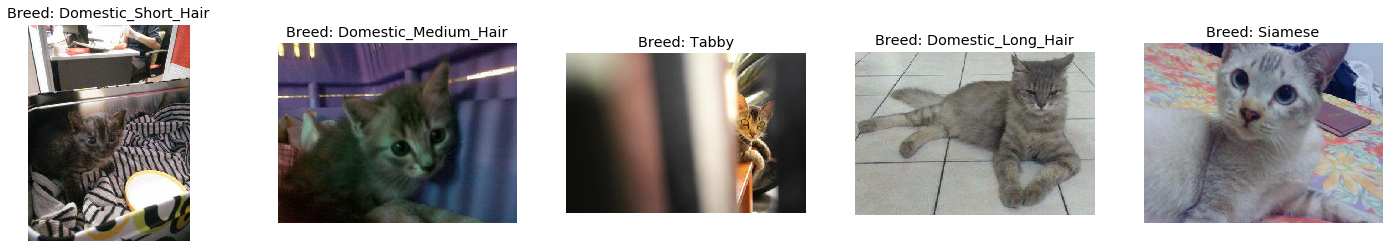

Most common Breeds of Large Cats:


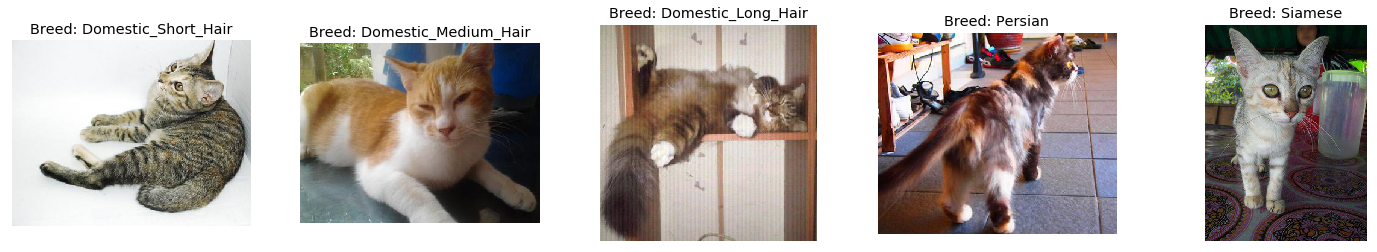

Most common Breeds of Extra Large Cats:


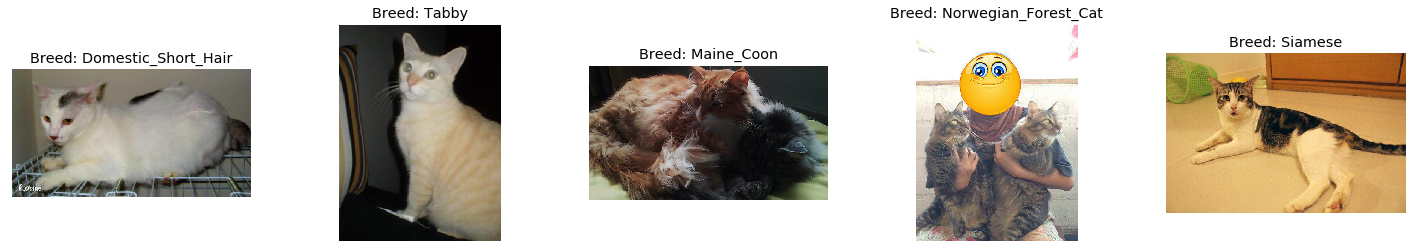

Most common Breeds of Small Dogs:


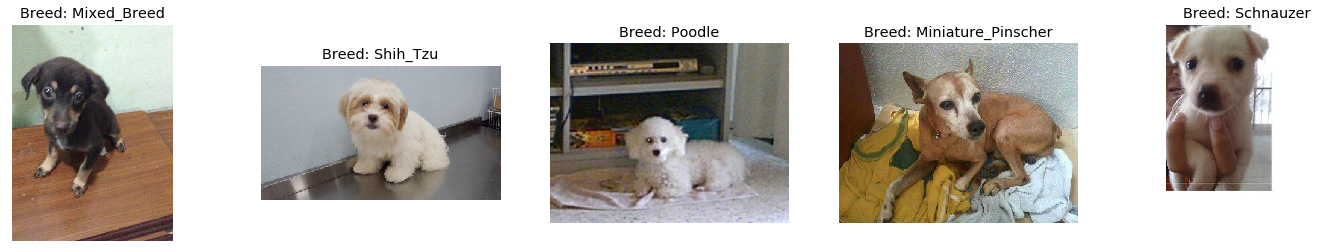

Most common Breeds of Medium Dogs:


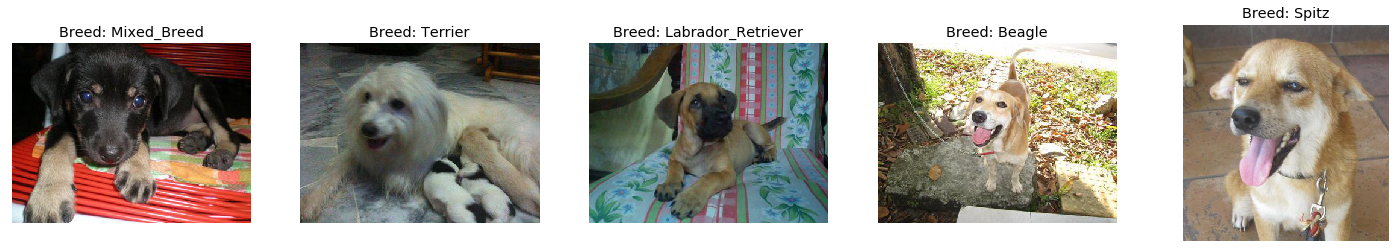

Most common Breeds of Large Dogs:


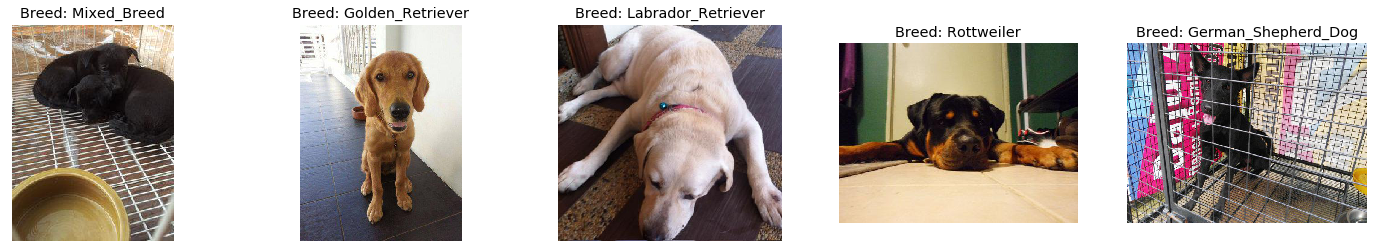

Most common Breeds of Extra Large Dogs:


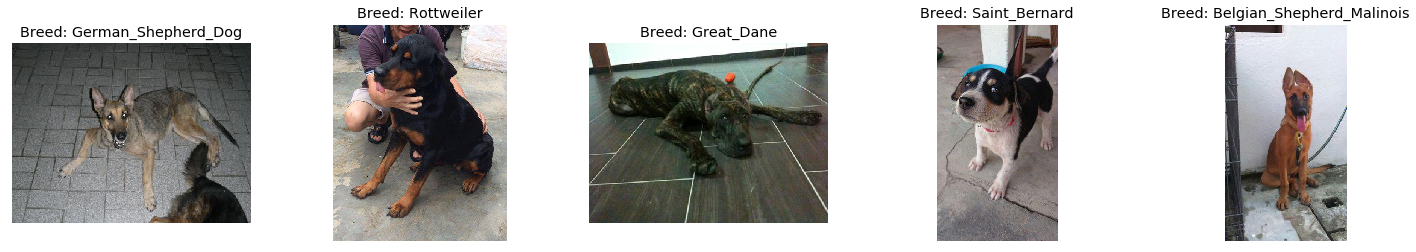

In [53]:
images = [i.split('-')[0] for i in os.listdir('D:/projects-Ravi/Data Exploration step by step Python/Inputs/train_images/')]
size_dict = {1: 'Small', 2: 'Medium', 3: 'Large', 4: 'Extra Large'}
for t in all_data['Type'].unique():
    for m in all_data['MaturitySize'].unique():
        df = all_data.loc[(all_data['Type'] == t) & (all_data['MaturitySize'] == m)]
        top_breeds = list(df['Breed1_name'].value_counts().index)[:5]
        m = size_dict[m]
        print(f"Most common Breeds of {m} {t}s:")
        
        fig = plt.figure(figsize=(25, 4))
        
        for i, breed in enumerate(top_breeds):
            # excluding pets without pictures
            b_df = df.loc[(df['Breed1_name'] == breed) & (df['PetID'].isin(images)), 'PetID']
            if len(b_df) > 1:
                pet_id = b_df.values[1]
            else:
                pet_id = b_df.values[0]
            ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])

            im = Image.open("D:/projects-Ravi/Data Exploration step by step Python/Inputs/train_images/" + pet_id + '-1.jpg')
            plt.imshow(im)
            ax.set_title(f'Breed: {breed}')
        plt.show();


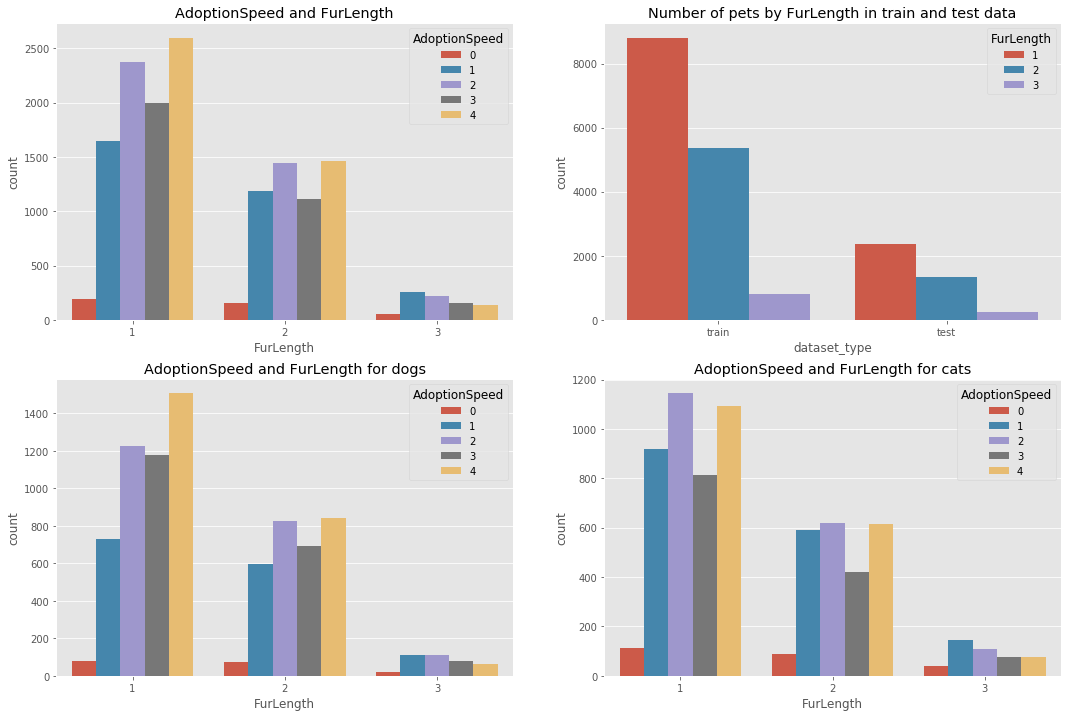

In [54]:
#FurLength¶

#(1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
plt.figure(figsize=(18, 12));
plt.subplot(2, 2, 1)
sns.countplot(x='FurLength', data=train, hue='AdoptionSpeed');
plt.title('AdoptionSpeed and FurLength');

plt.subplot(2, 2, 2)
sns.countplot(x='dataset_type', data=all_data, hue='FurLength');
plt.title('Number of pets by FurLength in train and test data');

plt.subplot(2, 2, 3)
sns.countplot(x='FurLength', data=train.loc[train['Type'] == 1], hue='AdoptionSpeed');
plt.title('AdoptionSpeed and FurLength for dogs');

plt.subplot(2, 2, 4)
sns.countplot(x='FurLength', data=train.loc[train['Type'] == 2], hue='AdoptionSpeed');
plt.title('AdoptionSpeed and FurLength for cats');

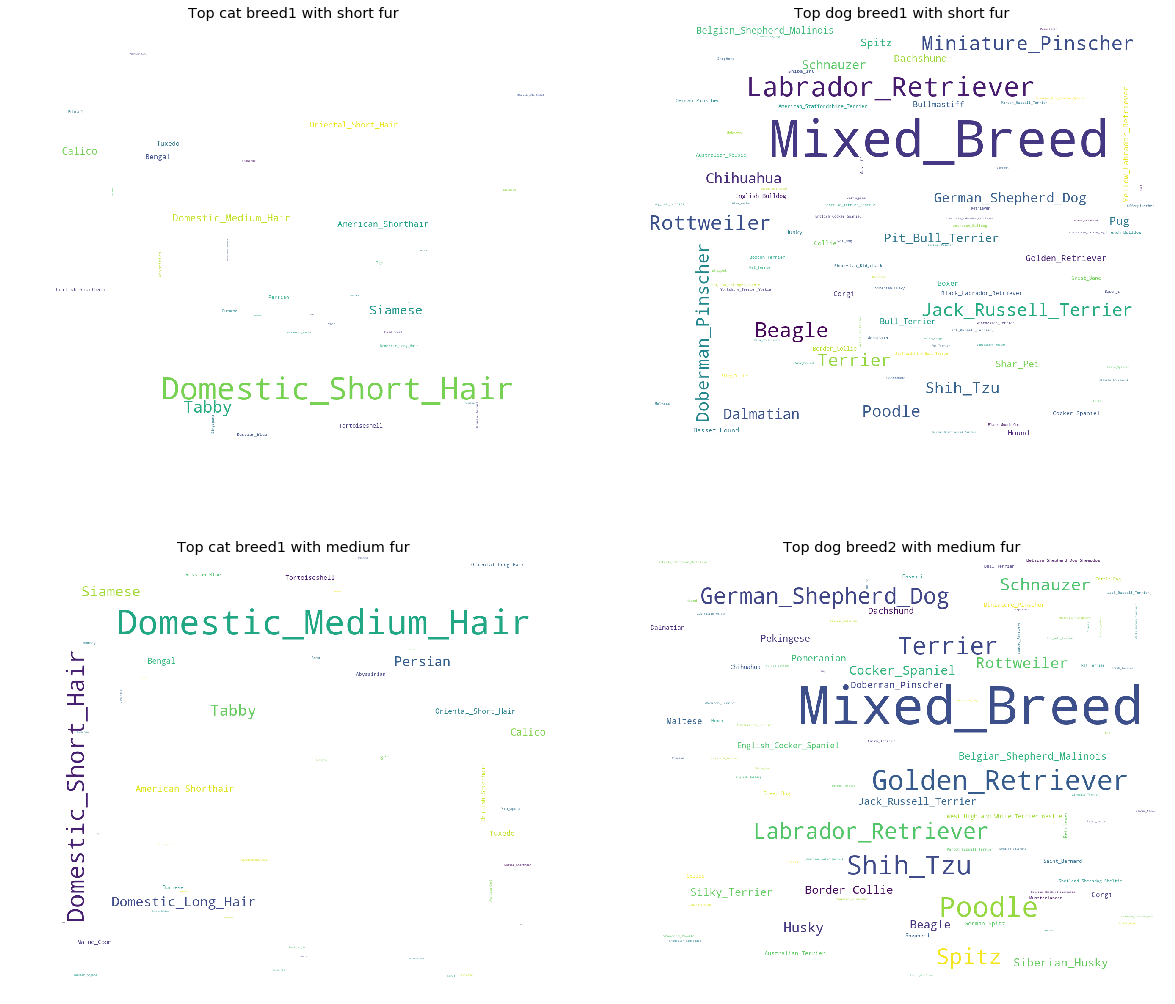

In [55]:




fig, ax = plt.subplots(figsize = (20, 18))
plt.subplot(2, 2, 1)
text_cat1 = ' '.join(all_data.loc[(all_data['FurLength'] == 1) & (all_data['Type'] == 'Cat'), 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text_cat1)
plt.imshow(wordcloud)
plt.title('Top cat breed1 with short fur')
plt.axis("off")

plt.subplot(2, 2, 2)
text_dog1 = ' '.join(all_data.loc[(all_data['FurLength'] == 1) & (all_data['Type'] == 'Dog'), 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text_dog1)
plt.imshow(wordcloud)
plt.title('Top dog breed1 with short fur')
plt.axis("off")

plt.subplot(2, 2, 3)
text_cat2 = ' '.join(all_data.loc[(all_data['FurLength'] == 2) & (all_data['Type'] == 'Cat'), 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text_cat2)
plt.imshow(wordcloud)
plt.title('Top cat breed1 with medium fur')
plt.axis("off")

plt.subplot(2, 2, 4)
text_dog2 = ' '.join(all_data.loc[(all_data['FurLength'] == 2) & (all_data['Type'] == 'Dog'), 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text_dog2)
plt.imshow(wordcloud)
plt.title('Top dog breed2 with medium fur')
plt.axis("off")
plt.show()


In [56]:
c = 0
strange_pets = []
for i, row in all_data[all_data['Breed1_name'].str.contains('air')].iterrows():
    if 'Short' in row['Breed1_name'] and row['FurLength'] == 1:
        pass
    elif 'Medium' in row['Breed1_name'] and row['FurLength'] == 2:
        pass
    elif 'Long' in row['Breed1_name'] and row['FurLength'] == 3:
        pass
    else:
        c += 1
        strange_pets.append((row['PetID'], row['Breed1_name'], row['FurLength']))
        
print(f"There are {c} pets whose breed and fur length don't match")

There are 964 pets whose breed and fur length don't match


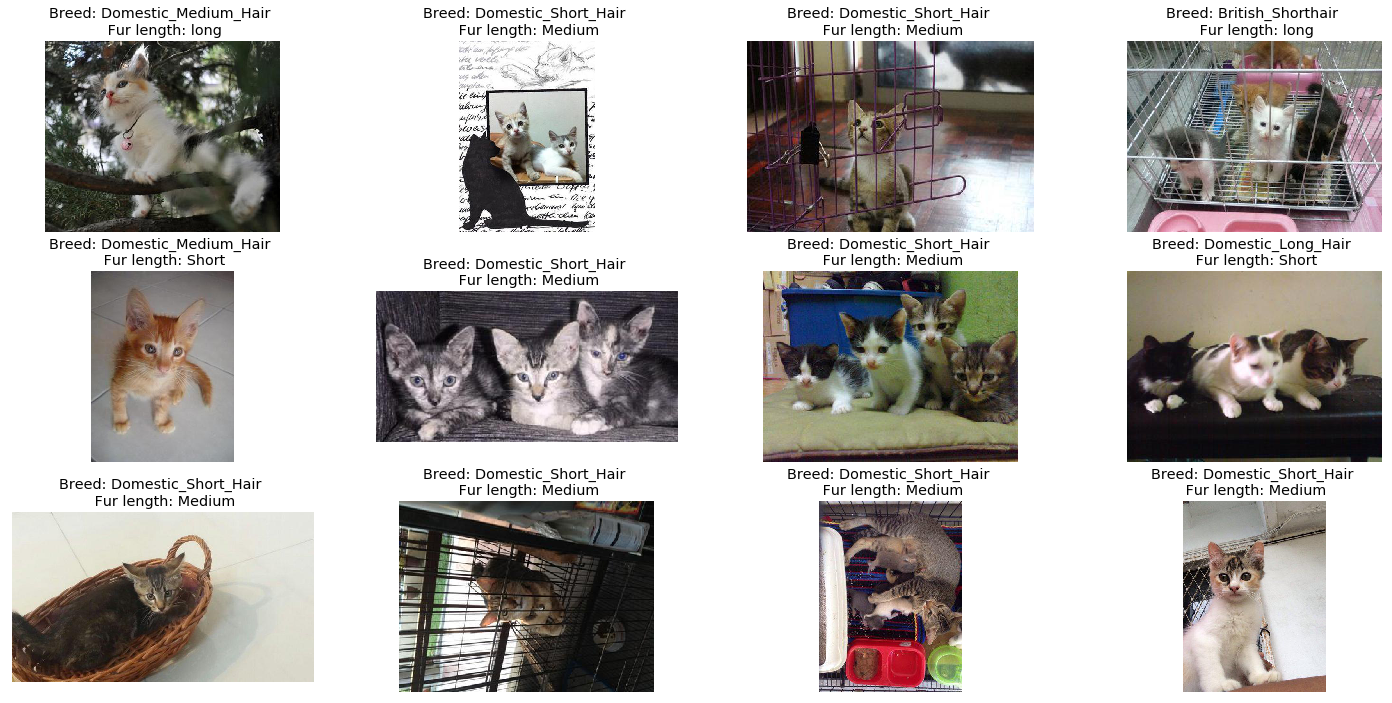

In [58]:
strange_pets = [p for p in strange_pets if p[0] in images]
fig = plt.figure(figsize=(25, 12))
fur_dict = {1: 'Short', 2: 'Medium', 3: 'long'}
for i, s in enumerate(random.sample(strange_pets, 12)):
    ax = fig.add_subplot(3, 4, i+1, xticks=[], yticks=[])

    im = Image.open("D:/projects-Ravi/Data Exploration step by step Python/Inputs/train_images/" + s[0] + '-1.jpg')
    plt.imshow(im)
    ax.set_title(f'Breed: {s[1]} \n Fur length: {fur_dict[s[2]]}')

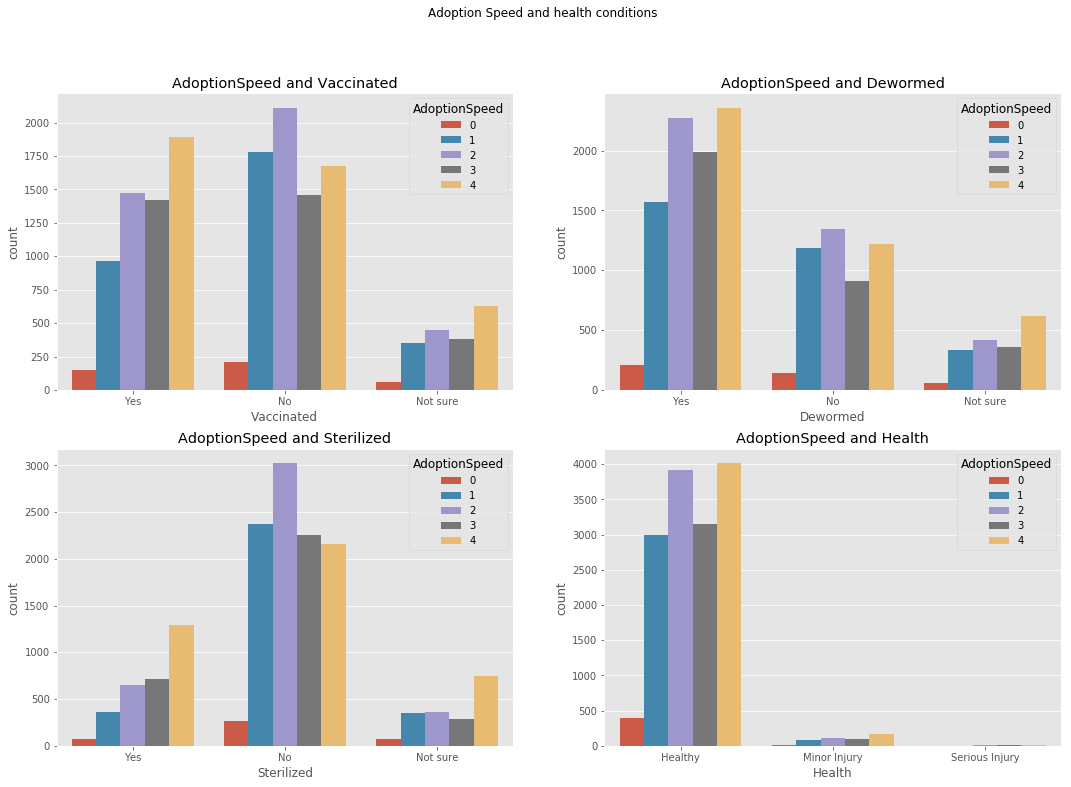

In [59]:
#Health

plt.figure(figsize=(18, 12));
plt.subplot(2, 2, 1)
sns.countplot(x='Vaccinated', data=train, hue='AdoptionSpeed');
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('AdoptionSpeed and Vaccinated');

plt.subplot(2, 2, 2)
sns.countplot(x='Dewormed', data=train, hue='AdoptionSpeed');
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('AdoptionSpeed and Dewormed');

plt.subplot(2, 2, 3)
sns.countplot(x='Sterilized', data=train, hue='AdoptionSpeed');
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('AdoptionSpeed and Sterilized');

plt.subplot(2, 2, 4)
sns.countplot(x='Health', data=train, hue='AdoptionSpeed');
plt.xticks([0, 1, 2], ['Healthy', 'Minor Injury', 'Serious Injury']);
plt.title('AdoptionSpeed and Health');

plt.suptitle('Adoption Speed and health conditions');


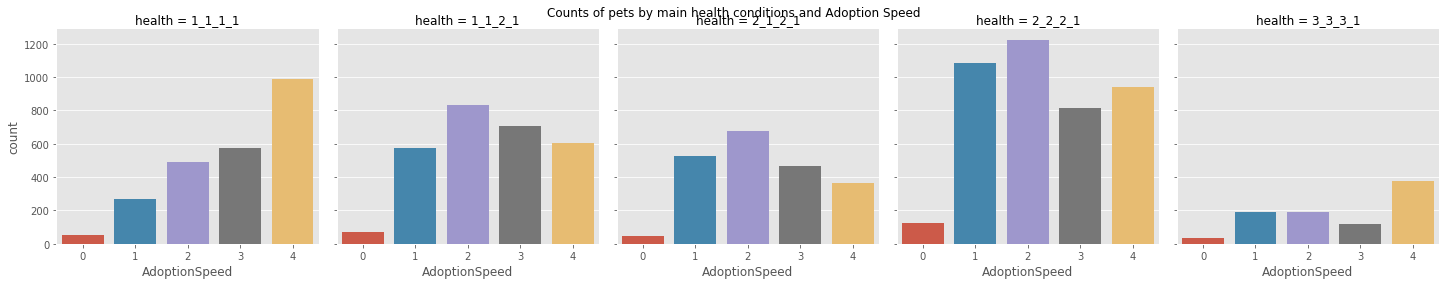

In [60]:
train['health'] = train['Vaccinated'].astype(str) + '_' + train['Dewormed'].astype(str) + '_' + train['Sterilized'].astype(str) + '_' + train['Health'].astype(str)
test['health'] = test['Vaccinated'].astype(str) + '_' + test['Dewormed'].astype(str) + '_' + test['Sterilized'].astype(str) + '_' + test['Health'].astype(str)

sns.factorplot('AdoptionSpeed', col='health', data=train.loc[train['health'].isin(list(train.health.value_counts().index[:5]))], kind='count');
plt.subplots_adjust(top=0.9)
plt.suptitle('Counts of pets by main health conditions and Adoption Speed');

In [61]:
train.loc[train['Quantity'] > 11][['Name', 'Description', 'Quantity', 'AdoptionSpeed']].head(10)

Name  \
263                    20 Little Puppies   
320             18 Cats For NEED HOMES!!   
396    Giant, Cookie & Snoopy. ! Thanks!   
427                         OMIEY'S HOME   
823                        Pancho & Tita   
1302                             Unnamed   
1305                              Bailey   
1404                             Unnamed   
1659  Cats From TTDI Now In Omiey's Home   
2558     ( 0 Puppies Left  )14+2 Puppies   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Description  \
263                                                                                                                                                                                                                                                                                                                              These are 20 puppies, from 2 stray mums need good homes. They are 2 weeks old. If you can give them a good home without caging or chaining, please whatsapp or msg Ms Grace Bong tel no:   
320   YOU can CONTACT the couple at if you are interested. MORE pictures available here: THE HISTORY: They were basically abandoned by their previous owner who left them behind when he moved out. The couple that moved in was left to look after them and has slowly been finding homes for the cats over the last year. There were 28 to begin with and there are 18 left. The last 18 NEED HOMES URGENTLY as the couple is no longer able to care for them. Due to some personal issues, and a new baby then need...   
396   puppies for adoption. Rescued by some good samaritans. No information on breeds, probably mongrels. All about a month old. They have been dewormed but not yet vaccinated. Cookie- female- Smaller than the rest but fiesty! Snoopy- male- Attention seeker. LOVES wagging his tail! Giant- male- Gentle giant. Very soft fur coat! Very playful! Some videos: Giant and his tennis ball- Giant playing with Snoopy- Giant being bullied- ----------------------------------------------------------------------...   
427                                                                                                                                                                                                                                                                                                                                                                        Hi, kepada sesiapa yang berminat untuk adopt kucing-kucing sila hubungi saya . Di sini ada berbagai jenis kucing, dari short hair - long hair.   
823                                                                                                                                                                                                                                                  Pancho and Tita are 2 adorable, playful kittens. They can be shy at first but once they get to know you they are the sweetest pets anyone could ask for. Available for adoption now. They are very, very close so we are looking for someone who can take them both.   
1302                                                                        Sebare Bengal is a specialist catery breeding quality bengal cats. View our web Due to our passion with cats, we have rescued and feed the stray cats until its become healty and ready to go to a new family. Currently, we have 14 DSH ready for adoption from age 3 months to year. 3 male and 11 female. Adoption fee is free but if you kind enough, we will be appreciate if you can donate IAMS Chicken foods for us to feed t

In [62]:
train['Quantity'].value_counts().head(10)

1     11565
2      1422
3       726
4       531
5       333
6       185
7        84
8        52
9        33
10       19
Name: Quantity, dtype: int64

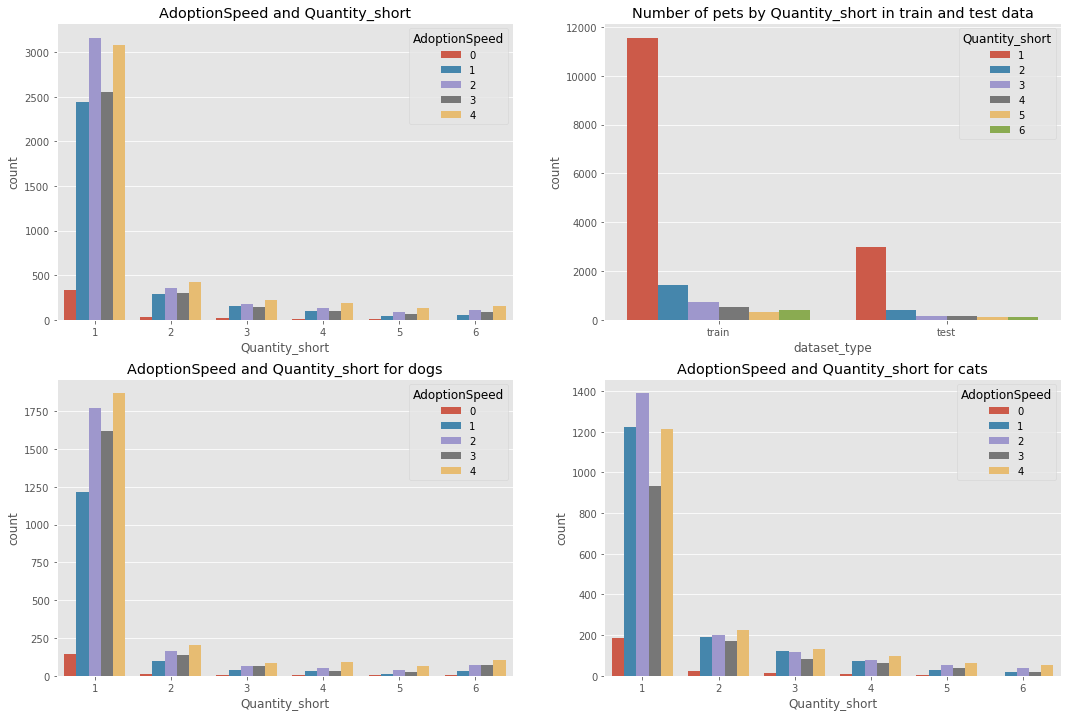

In [63]:
train['Quantity_short'] = train['Quantity'].apply(lambda x: x if x <= 5 else 6)
test['Quantity_short'] = test['Quantity'].apply(lambda x: x if x <= 5 else 6)
all_data['Quantity_short'] = all_data['Quantity'].apply(lambda x: x if x <= 5 else 6)

plt.figure(figsize=(18, 12));
plt.subplot(2, 2, 1)
sns.countplot(x='Quantity_short', data=train, hue='AdoptionSpeed');
plt.title('AdoptionSpeed and Quantity_short');

plt.subplot(2, 2, 2)
sns.countplot(x='dataset_type', data=all_data, hue='Quantity_short');
plt.title('Number of pets by Quantity_short in train and test data');

plt.subplot(2, 2, 3)
sns.countplot(x='Quantity_short', data=train.loc[train['Type'] == 1], hue='AdoptionSpeed');
plt.title('AdoptionSpeed and Quantity_short for dogs');

plt.subplot(2, 2, 4)
sns.countplot(x='Quantity_short', data=train.loc[train['Type'] == 2], hue='AdoptionSpeed');
plt.title('AdoptionSpeed and Quantity_short for cats');

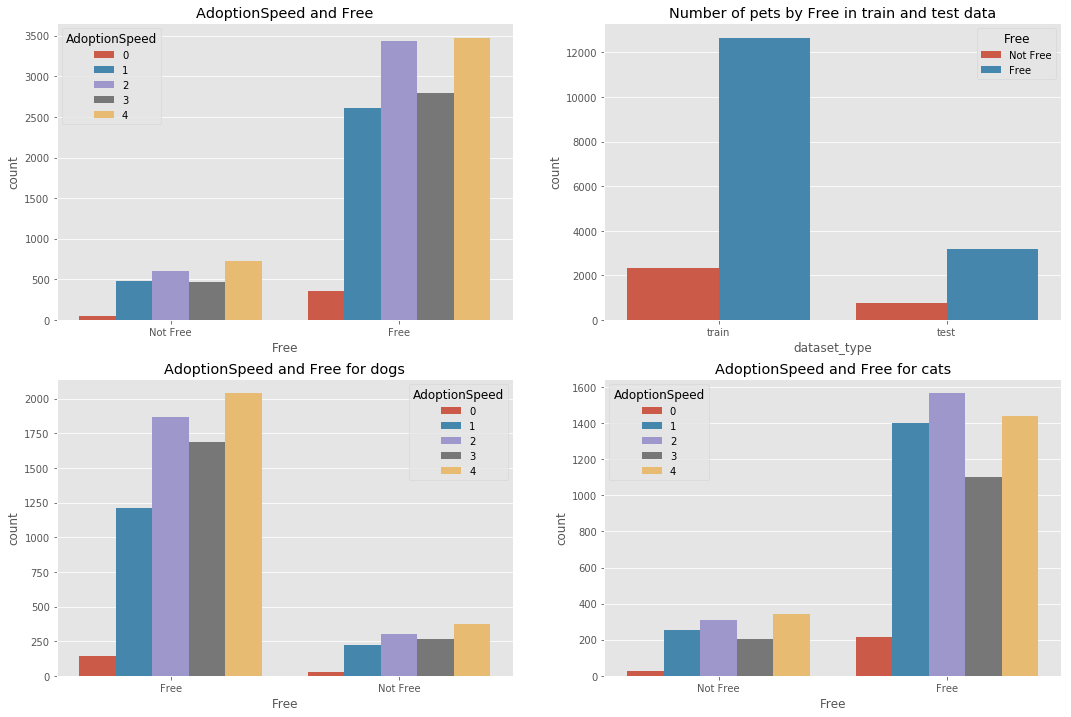

In [64]:
# fee
train['Free'] = train['Fee'].apply(lambda x: 'Free' if x == 0 else 'Not Free')
test['Free'] = test['Fee'].apply(lambda x: 'Free' if x == 0 else 'Not Free')
all_data['Free'] = all_data['Fee'].apply(lambda x: 'Free' if x == 0 else 'Not Free')

plt.figure(figsize=(18, 12));
plt.subplot(2, 2, 1)
sns.countplot(x='Free', data=train, hue='AdoptionSpeed');
plt.title('AdoptionSpeed and Free');

plt.subplot(2, 2, 2)
sns.countplot(x='dataset_type', data=all_data, hue='Free');
plt.title('Number of pets by Free in train and test data');

plt.subplot(2, 2, 3)
sns.countplot(x='Free', data=train.loc[train['Type'] == 1], hue='AdoptionSpeed');
plt.title('AdoptionSpeed and Free for dogs');

plt.subplot(2, 2, 4)
sns.countplot(x='Free', data=train.loc[train['Type'] == 2], hue='AdoptionSpeed');
plt.title('AdoptionSpeed and Free for cats');


In [65]:
all_data.sort_values('Fee', ascending=False)[['Name', 'Description', 'Fee', 'AdoptionSpeed', 'dataset_type']].head(10)

Name  \
8722                 Khaleesi And Drogo   
1604   Fife Registered Exotic Long Hair   
10477                          Bull Dog   
2078              Rottweiler - Adoption   
1792                            NO NAME   
8834                            Adpoted   
8879   Rottweiler Semi-Adult - Adoption   
4844                               Coda   
3425                            Unnamed   
9745                              Oscar   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Description  \
8722   Both pups are family home trained. They love their walks on lead and off lead. Both male and female are from different lineage and both have MKA Reg Certs. They are 4mths and at perfect age for training. The 2pups know some commands like "sit" "outside" "leave" "crate" and more. They are family friendly and can stay/sleep indoors and out. They've just learnt to swim and belly rubs. Great dogs for families that wants a pet and a watchdog too. All vaccines complete, dewormed, microchipped and ...   
1604                                                                                                                                                                                                                                                                                                                                                                                                 -female -5 months -intact( non neuter) -FIFE registerated -vaccinated n dewormed -breeding quality any interested sms   
10477                                                                                     Found this bull dog near my neighbourhood for a month now. I have 3 dogs myself at home. Cannot take care of it. Hopefully if there is someone who is loving who can take care of it. It is very cute and friendly but the saliva keep on drooling. overall there is nothing. forgot to mention, please keep him indoor. He likes to sleep on mattress or sofa, if can please prepare a mattress for him. PLEASE SMS , DONT CALL   
2078                                                                                                                                                                                                                                                                                                                                                               Open for Adoption with Fees Looking for new lovely home due to owner lack of time & care... Vaccination & Deworm up to date Contact me for more details   
1792                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              GOOD BOY   
8834                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               ad

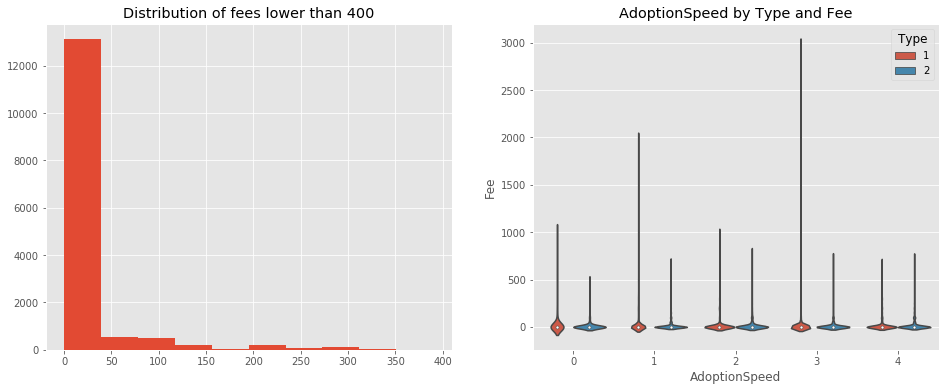

In [66]:
plt.figure(figsize=(16, 6));
plt.subplot(1, 2, 1)
plt.hist(train.loc[train['Fee'] < 400, 'Fee']);
plt.title('Distribution of fees lower than 400');

plt.subplot(1, 2, 2)
sns.violinplot(x="AdoptionSpeed", y="Fee", hue="Type", data=train);
plt.title('AdoptionSpeed by Type and Fee');

In [69]:
plt.figure(figsize=(16, 10));
sns.scatterplot(x="Fee", y="Quantity", hue="Type",data=all_data);
plt.title('Quantity of pets and Fee');

AttributeError: module 'seaborn' has no attribute 'scatterplot'

<Figure size 1152x720 with 0 Axes>